# INITIAL SETUP

In [200]:
import pandas as pd
import os
import numpy as np
import seaborn as sns                      
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,f1_score,precision_score,recall_score
            
%matplotlib inline     
sns.set(color_codes=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
data = pd.read_csv("../data/cleaned/FIFA_players_21_cleaned.csv")


# DATA PREPROCESSING

Copying and changing columns to minimalize skewness. Also deleting unnecessary columns

In [188]:
df = data.copy()
correlations = {}
for col in df.columns:
    if col != 'value_eur_m' and df[col].dtype != 'object':
        correlations[col] = df['value_eur_m'].corr(df[col])

sorted_corr = dict(sorted(correlations.items(), key=lambda item: item[1], reverse=True))

for col, corr in sorted_corr.items():
    print(f"Correlation between value_eur_m and {col}: {corr:.4f}")

cols_to_log = ['wage_eur_year_m', 'value_eur_m', 'release_clause_eur_m']
for col in cols_to_log:
    df[col] = np.log1p(df[col])
df.drop(["sofifa_id","player_url","short_name","long_name","dob","joined","club_name","league_name","player_positions","nationality","release_clause_eur_m","wage_eur_year_m","overall","potential","movement_reactions","skill_ball_control"],axis=1,inplace=True)

Correlation between value_eur_m and release_clause_eur_m: 0.9941
Correlation between value_eur_m and wage_eur_year_m: 0.8398
Correlation between value_eur_m and overall: 0.6373
Correlation between value_eur_m and potential: 0.5756
Correlation between value_eur_m and international_reputation: 0.5698
Correlation between value_eur_m and movement_reactions: 0.5647
Correlation between value_eur_m and mentality_composure: 0.4529
Correlation between value_eur_m and player_traits: 0.4071
Correlation between value_eur_m and mentality_vision: 0.3705
Correlation between value_eur_m and power_shot_power: 0.3579
Correlation between value_eur_m and attacking_short_passing: 0.3333
Correlation between value_eur_m and skill_long_passing: 0.3156
Correlation between value_eur_m and skill_ball_control: 0.3035
Correlation between value_eur_m and skill_moves: 0.2964
Correlation between value_eur_m and skill_curve: 0.2940
Correlation between value_eur_m and attacking_volleys: 0.2733
Correlation between value

Encodding with label and one hot

In [189]:
def encoder(df, col):
    if df[col].dtype == 'object':
        n_unique = df[col].nunique()
        
        if n_unique <= 2:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            return df
        
        elif 2 < n_unique <= 10:
            ohe = OneHotEncoder()
            ohe_df = pd.DataFrame(ohe.fit_transform(df[[col]]).toarray())
            ohe_df.columns = [col + "_" + str(i) for i in ohe_df.columns]
            df = df.drop(col, axis=1).join(ohe_df)
            return df
        else:
            return df
            
    else:
        return df
       
for i in df.columns:
    df = encoder(df, i)

Saving csv file that is used for training models

In [190]:
output_dir = "C:/Users/cozid/OneDrive/Desktop/data-science-internship/data/cleaned"  
filename = "fifa_players_21_model.csv"
output_path = os.path.join(output_dir, filename)

df.to_csv(output_path, index=False)
print(f"File saved to: {output_path}")

File saved to: C:/Users/cozid/OneDrive/Desktop/data-science-internship/data/cleaned\fifa_players_21_model.csv


X, Y split and training split

In [191]:
x = df.drop(["value_eur_m"], axis=1)
y = df["value_eur_m"]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=100)

print("X_train shape: ",x_train.shape)
print("X_test shape: ",x_test.shape)
print("Y_train shape: ",y_train.shape)
print("Y_test shape: ",y_test.shape)

X_train shape:  (14965, 75)
X_test shape:  (3742, 75)
Y_train shape:  (14965,)
Y_test shape:  (3742,)


Using a scaler (optional)

In [192]:
original_columns = x_train.columns
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# MODEL TRAINING AND EVALUATION

Messing around

In [193]:
lr = LinearRegression()
lr.fit(x_train,y_train)
y_lr_train_pred=lr.predict(x_train)
y_lr_test_pred=lr.predict(x_test)

In [194]:
y_lr_train_pred

array([1.26344983, 0.39757377, 1.59892093, ..., 0.46929638, 0.27326653,
       0.90833269], shape=(14965,))

In [195]:
#y_train

Actual model training generalized. Scores

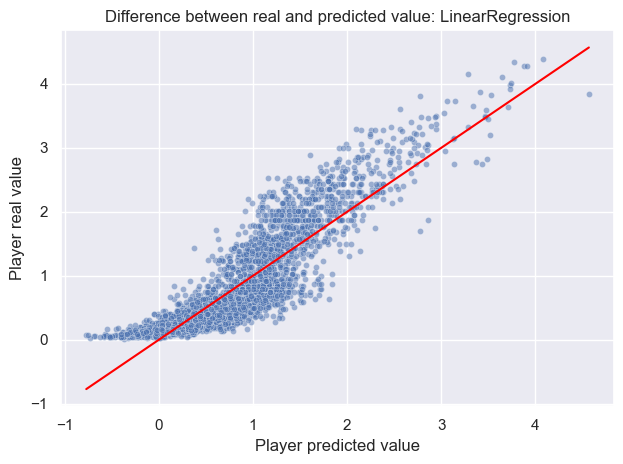

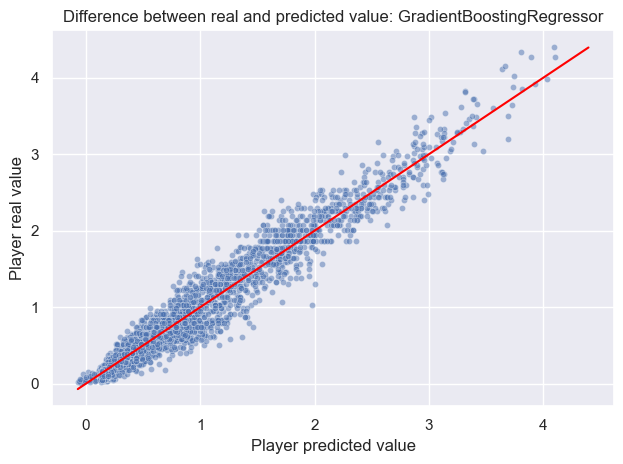

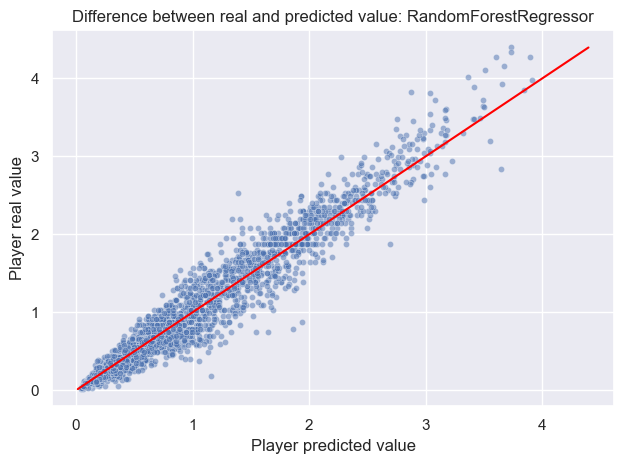

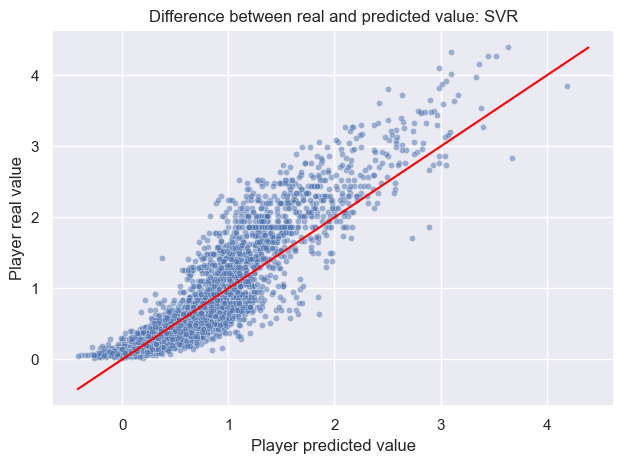

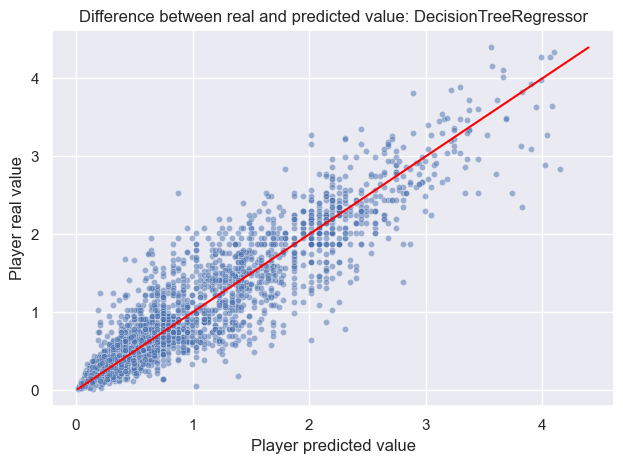

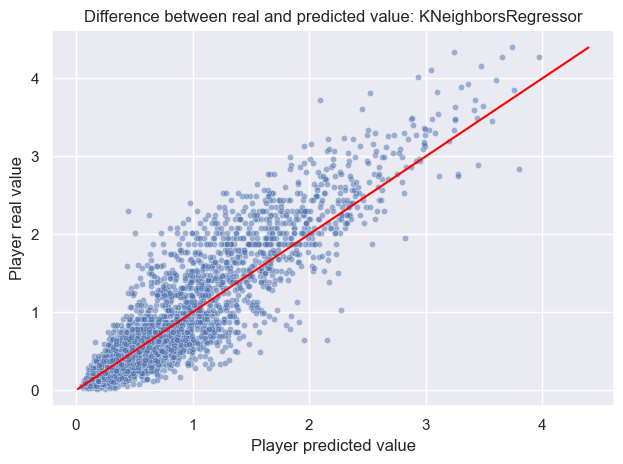

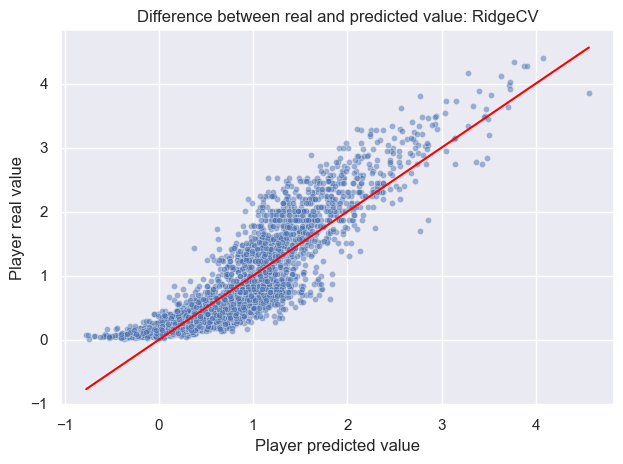

,Model,R2 Train,R2 Test,MSE Train,MSE Test,RMSE Train,RMSE Test,MAE Train,MAE Test
1,GradientBoostingRegressor,0.959649,0.953006,0.021897,0.026719,0.147976,0.163461,0.105064,0.115235
2,RandomForestRegressor,0.992955,0.949752,0.003823,0.028570,0.061832,0.169027,0.039849,0.109741
4,DecisionTreeRegressor,1.000000,0.870098,0.000000,0.073859,0.000000,0.271770,0.000000,0.173534
5,KNeighborsRegressor,0.878961,0.824259,0.065682,0.099922,0.256285,0.316104,0.170825,0.209811
3,SVR,0.809642,0.806879,0.103298,0.109804,0.321400,0.331367,0.225502,0.231447
6,RidgeCV,0.791979,0.792322,0.112883,0.118080,0.335981,0.343628,0.259611,0.265391
0,LinearRegression,0.791993,0.792228,0.112876,0.118134,0.335970,0.343706,0.259633,0.265505


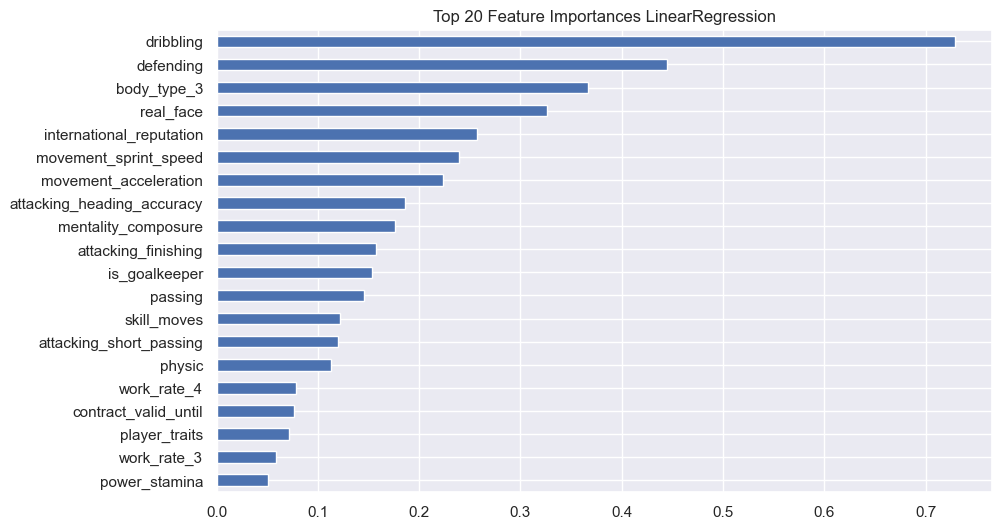

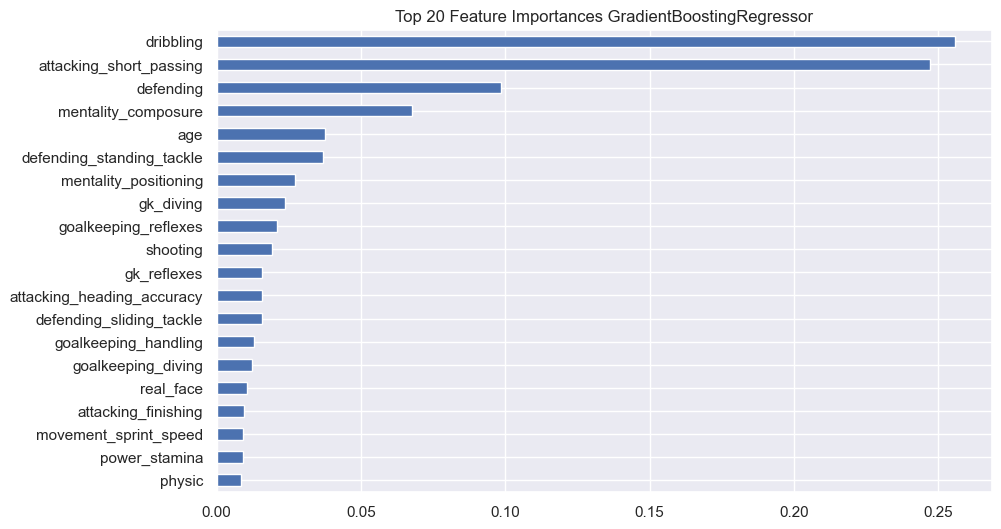

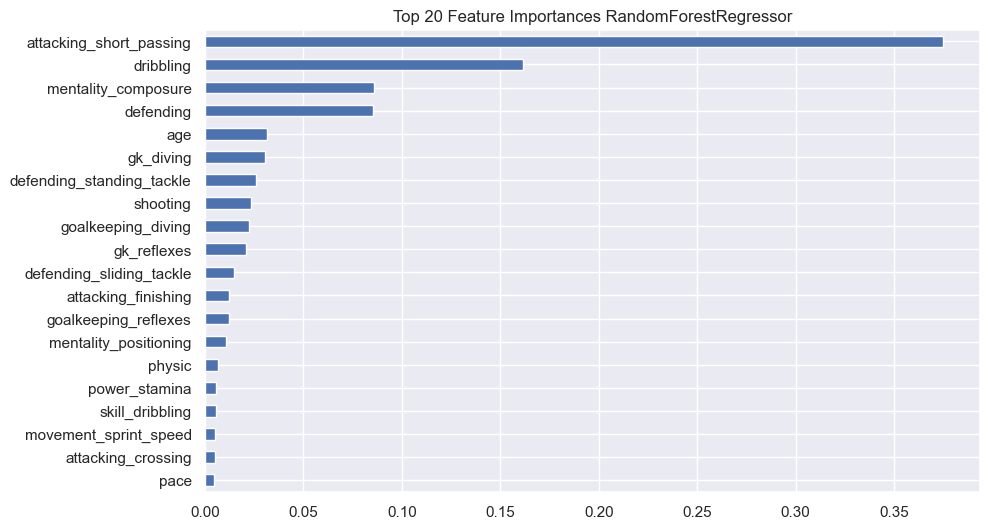

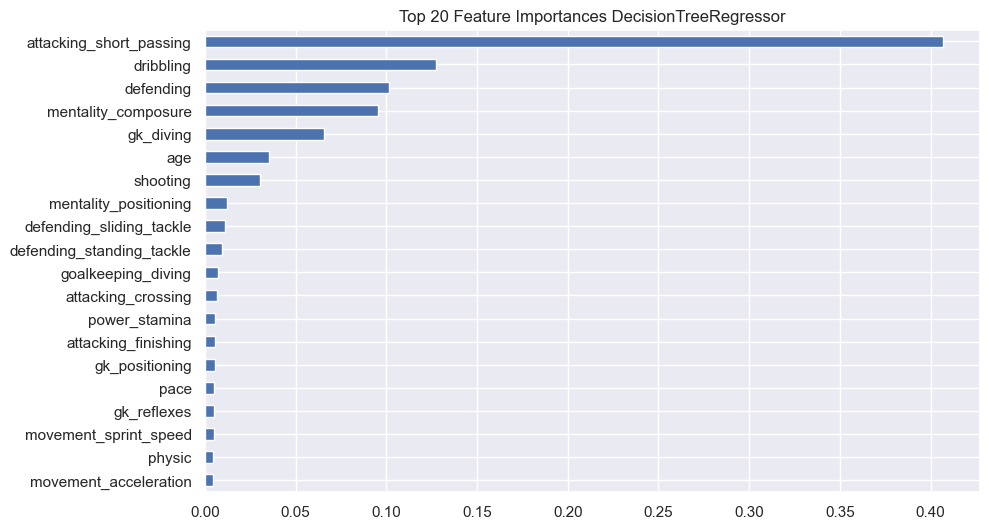

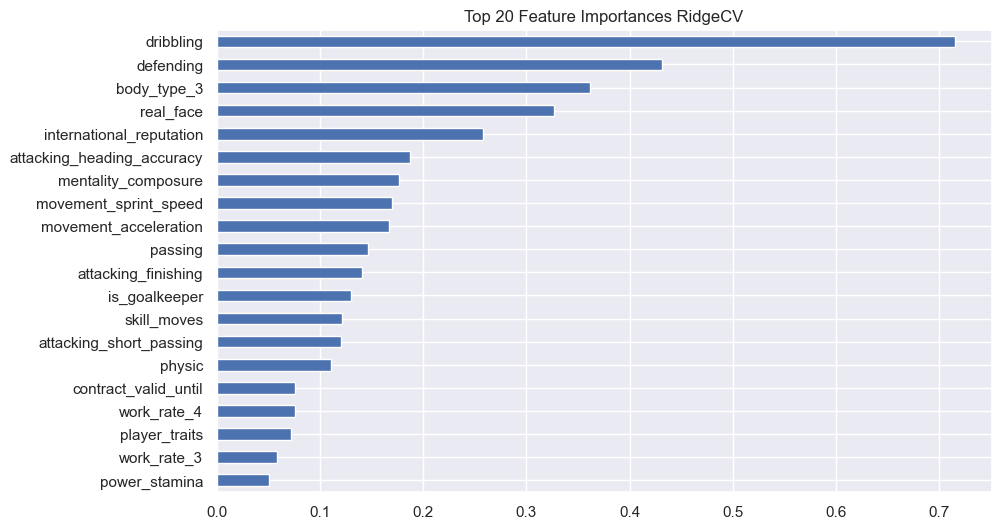

In [196]:
lr = LinearRegression()
gbr = GradientBoostingRegressor()
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()
knn = KNeighborsRegressor()
svr = SVR()
rg = RidgeCV(alphas=np.logspace(-3, 3, 50))
models = [lr,gbr,rf,svr,dt,knn,rg]
models_imp = [gbr, rf, dt]

results = []

for model in models:
    model.fit(x_train, y_train)
    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    
    r2_train = r2_score(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)

    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    sns.scatterplot(x=y_pred_test, y=y_test, alpha=0.5, s=20, legend=False)
    plt.title(f'Difference between real and predicted value: {model.__class__.__name__}')
    plt.xlabel('Player predicted value')
    plt.ylabel('Player real value')

    min_val = min(min(y_pred_test), min(y_test))
    max_val = max(max(y_pred_test), max(y_test))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='-', label='y = x')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    results.append({
        "Model": model.__class__.__name__,
        "R2 Train": r2_train,
        "R2 Test": r2_test,
        "MSE Train": mse_train,
        "MSE Test":mse_test,
        "RMSE Train": rmse_train,
        "RMSE Test": rmse_test,
        "MAE Train": mae_train,
        "MAE Test": mae_test,
    })
overral = pd.DataFrame(results)

overral = overral.sort_values(by="R2 Test", ascending=False)
overral = overral.style.background_gradient(cmap="viridis")
display(overral)

for model in models:
    if hasattr(model, 'feature_importances_'):
        feat_imp = pd.Series(model.feature_importances_, index=original_columns)
    elif hasattr(model, 'coef_'):
        feat_imp = pd.Series(model.coef_.ravel(), index=original_columns)
    else:
        continue
    feat_imp = feat_imp.sort_values(ascending=False)
    feat_imp.nlargest(20).plot(kind='barh', figsize=(10, 6), title=f'Top 20 Feature Importances {model.__class__.__name__}')
    plt.gca().invert_yaxis()
    plt.show()





In [203]:
gb_params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [0.1, 0.3, 0.5, 0.7],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),param_grid=gb_params,cv=5,n_jobs=-1,verbose=1)

grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best R² score from CV:", grid_search.best_score_)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 6, 'max_features': 0.3, 'min_samples_leaf': 4, 'n_estimators': 300}
Best R² score from CV: 0.9697223035501805
